In [ ]:
# --- Notebook: 02_label_and_feature_analysis.ipynb ---
# Objective:
# - Analyse label distributions (device_mac, attack_label)
# - Quantify class imbalance and coverage
# - Inspect numeric features (variance, correlations)
# - Provide evidence tables for multitask 1D-CNN + MLP design

In [15]:
# ============================================================
# 1. Environment setup & Configuration
# ============================================================

import sys
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)

# Assumes this notebook is in <project_root>/notebooks/
PROJECT_ROOT = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))

from src.data.load_data import IoTDatasetLoader


BASE_PATH = Path(
    "/Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024"
)

# Sample configuration (≈ 1.2M rows)
MAX_PACKET_FILES_FOR_SAMPLE = 12        # first 12 packet files
ROWS_PER_PACKET_FILE_SAMPLE = 100_000   # 100k rows per file

ATTACK_KEYWORDS = {
    "ddos": "ddos",
    "mirai": "mirai",
    "dos": "dos",
    "benign": "benign",
    "recon": "recon",
    "spoof": "spoofing",
    "web": "web-based",
    "bruteforce": "brute force",
    "brute_force": "brute force",
    "brute-force": "brute force",
}

REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


In [16]:
# ============================================================
# 2. Helper functions
# ============================================================

def infer_attack_label_from_filename(file_path: str) -> str:
    """
    Simple keyword-based label from file path. Used as fallback.
    """
    p = file_path.lower()
    for k, v in ATTACK_KEYWORDS.items():
        if k in p:
            return v
    return "unknown"


def detect_attack_label_column(df: pd.DataFrame, verbose: bool = True):
    """
    Try to locate the attack/benign label column using:
    1) column name (label/attack/family/category)
    2) overlap of string values with ATTACK_KEYWORDS
    """
    name_based = [
        c for c in df.columns
        if any(k in c.lower() for k in ["label", "attack", "family", "category"])
    ]

    content_based = []
    obj_cols = df.select_dtypes(include=["object"]).columns.tolist()

    for col in obj_cols:
        vals = (
            df[col]
            .dropna()
            .astype(str)
            .str.lower()
            .unique()
        )
        if len(set(vals) & set(ATTACK_KEYWORDS.values())) > 0:
            content_based.append(col)

    candidates = list(dict.fromkeys(name_based + content_based))

    if verbose:
        print("Attack label column detection:")
        print("  Name-based candidates   :", name_based)
        print("  Content-based candidates:", content_based)
        print("  Final candidate list    :", candidates)

    if not candidates:
        return None

    for c in candidates:
        if "label" in c.lower():
            return c
    return candidates[0]


def memory_usage_mb(df: pd.DataFrame) -> float:
    return df.memory_usage(deep=True).sum() / (1024 ** 2)

In [17]:
# ============================================================
# 3. Prepare packet-based file list
# ============================================================

loader = IoTDatasetLoader(BASE_PATH)
all_files = loader.list_files()
print(f"Total CSV files found: {len(all_files)}")

packet_files = [
    f for f in all_files
    if ("packet" in f.lower())
    or ("device identification_anomaly detection - packet based features".lower() in f.lower())
]
flow_files = [
    f for f in all_files
    if ("flow" in f.lower()) or ("cicflow" in f.lower())
]

if len(packet_files) == 0:
    packet_files = all_files

print(f"Packet-based CSV files (heuristic): {len(packet_files)}")
print(f"Flow-based   CSV files (heuristic): {len(flow_files)}")

print("\nExample packet-based files:")
for f in packet_files[:5]:
    print("  ", f)

Total CSV files found: 312
Packet-based CSV files (heuristic): 180
Flow-based   CSV files (heuristic): 132

Example packet-based files:
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic1.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic2.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic3.csv
   /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BruteForce/DictionaryBruteForce/D

In [18]:

# ============================================================
# 4. Build combined packet sample for analysis
# ============================================================

print("\nBuilding combined packet-based sample for deeper analysis...")

sample_dfs = []
selected_packet_files = packet_files[:MAX_PACKET_FILES_FOR_SAMPLE]

for i, fp in enumerate(selected_packet_files, start=1):
    print(f"  [{i}/{len(selected_packet_files)}] Loading sample from {fp}")
    df_tmp = loader.load_single(fp, nrows=ROWS_PER_PACKET_FILE_SAMPLE)
    df_tmp["attack_label_from_file"] = infer_attack_label_from_filename(fp)
    df_tmp["source_file"] = Path(fp).name
    sample_dfs.append(df_tmp)

packet_sample = pd.concat(sample_dfs, ignore_index=True)
print("\nCombined packet_sample shape:", packet_sample.shape)
print("Approx memory usage (MB):", round(memory_usage_mb(packet_sample), 2))
packet_sample.info()


Building combined packet-based sample for deeper analysis...
  [1/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic.csv
  [2/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic1.csv
  [3/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic2.csv
  [4/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/BenignTraffic/BenignTraffic3.csv
  [5/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection -

/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [7/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation1.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [8/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation10.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [9/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation11.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [10/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation12.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [11/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation2.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)


  [12/12] Loading sample from /Users/naeemulhassan/naeem-p/CIC_IoT_IDAD_2024/CIC_IoT_IDAD_Dataset_2024/Device Identification_Anomaly Detection - Packet Based Features/DDoS/DDoS-ACK_Fragmentation/DDoS-ACK_Fragmentation3.csv


/Users/naeemulhassan/naeem-p/Cloud-Deployed-Multitask-IoT-IDS/src/data/load_data.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(filepath, nrows=nrows)



Combined packet_sample shape: (1200000, 137)
Approx memory usage (MB): 2311.06
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Columns: 137 entries, stream to source_file
dtypes: float64(97), int64(22), object(18)
memory usage: 1.2+ GB


In [19]:
# ============================================================
# 5. Attach final attack_label
# ============================================================

attack_col = detect_attack_label_column(packet_sample, verbose=True)

if attack_col is not None:
    print(f"\nDetected attack label column: {attack_col}")
    packet_sample["attack_label"] = (
        packet_sample[attack_col]
        .astype(str)
        .str.strip()
        .str.lower()
    )
else:
    print("\nNo explicit attack label column detected; using filename-based label.")
    packet_sample["attack_label"] = (
        packet_sample["attack_label_from_file"]
        .astype(str)
        .str.strip()
        .str.lower()
    )

if "device_mac" not in packet_sample.columns:
    raise ValueError("device_mac column not found in packet_sample.")

Attack label column detection:
  Name-based candidates   : ['attack_label_from_file']
  Content-based candidates: ['attack_label_from_file']
  Final candidate list    : ['attack_label_from_file']

Detected attack label column: attack_label_from_file



[DI] device_mac distribution (top 30):
                          device_mac   count  percentage
0                  dc:a6:32:dc:27:d5  183353   15.279417
1               Arlo Q Indoor Camera  173344   14.445333
2                  dc:a6:32:c9:e4:ab  130064   10.838667
3                  dc:a6:32:c9:e4:90  110755    9.229583
4                  dc:a6:32:c9:e5:ef   82215    6.851250
5                  e4:5f:01:55:90:c4   63697    5.308083
6                  dc:a6:32:c9:e4:d5   55284    4.607000
7                 Nest Indoor Camera   52912    4.409333
8                  dc:a6:32:c9:e5:a4   45717    3.809750
9                  3c:18:a0:41:c3:a0   33357    2.779750
10                 ac:17:02:05:34:27   29504    2.458667
11                  Amazon Echo Show   16793    1.399417
12                 Amazon Echo Dot 2   15042    1.253500
13                    Netatmo Camera   14556    1.213000
14                 Amazon Echo Dot 1   10746    0.895500
15                 Sonos One Speaker   10027    

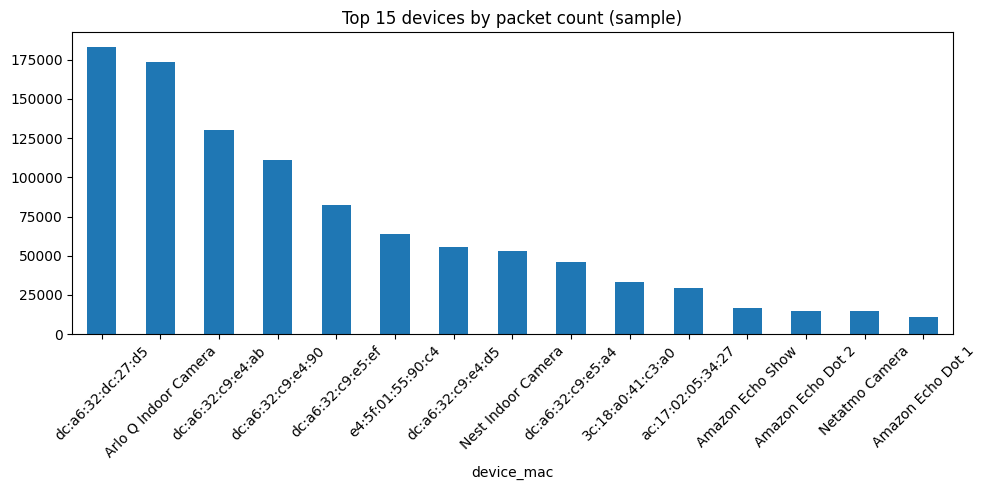

In [20]:
# ============================================================
# 6. Device label analysis (DI task)
# ============================================================

device_counts = (
    packet_sample["device_mac"]
    .value_counts()
    .reset_index()
)
device_counts.columns = ["device_mac", "count"]
device_counts["percentage"] = (
    100 * device_counts["count"] / device_counts["count"].sum()
)

print("\n[DI] device_mac distribution (top 30):")
print(device_counts.head(30))

print("\nNumber of device classes in this sample:", device_counts.shape[0])

device_counts.to_csv(
    REPORTS_DIR / "di_device_mac_distribution_sample.csv",
    index=False,
)

device_counts.head(15).plot(
    x="device_mac",
    y="count",
    kind="bar",
    title="Top 15 devices by packet count (sample)",
    legend=False,
    rot=45,
)
plt.tight_layout()
plt.show()



[AD] attack_label distribution (all):
  attack_label   count  percentage
0         ddos  700000   58.333333
1       benign  400000   33.333333
2  brute force  100000    8.333333


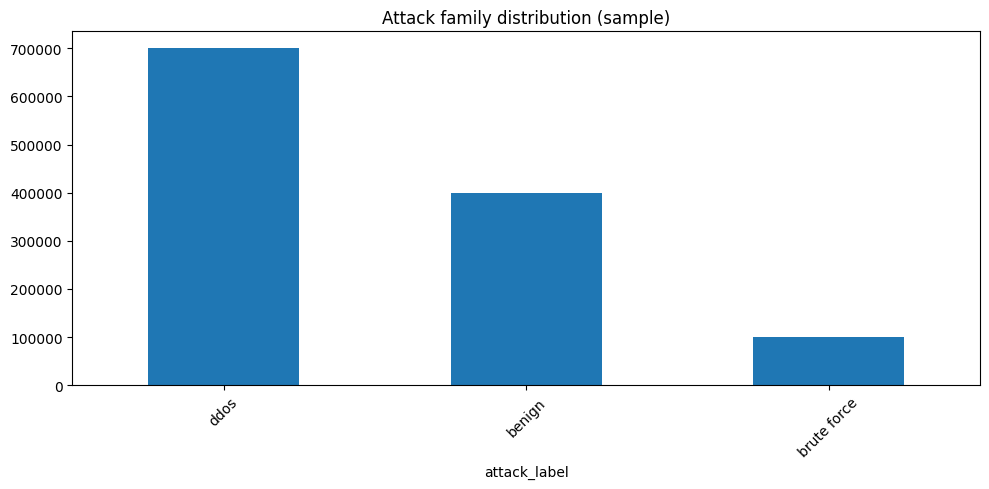

In [21]:
# ============================================================
# 7. Attack label analysis (AD task)
# ============================================================

attack_counts = (
    packet_sample["attack_label"]
    .value_counts()
    .reset_index()
)
attack_counts.columns = ["attack_label", "count"]
attack_counts["percentage"] = (
    100 * attack_counts["count"] / attack_counts["count"].sum()
)

print("\n[AD] attack_label distribution (all):")
print(attack_counts)

attack_counts.to_csv(
    REPORTS_DIR / "ad_attack_label_distribution_sample.csv",
    index=False,
)

attack_counts.plot(
    x="attack_label",
    y="count",
    kind="bar",
    title="Attack family distribution (sample)",
    legend=False,
    rot=45,
)
plt.tight_layout()
plt.show()


In [22]:
# ============================================================
# 8. Device vs attack crosstab (multitask evidence)
# ============================================================

crosstab_device_attack = (
    packet_sample
    .groupby(["device_mac", "attack_label"])
    .size()
    .reset_index(name="count")
)

print("\nDevice vs attack (top 40 rows by count):")
print(crosstab_device_attack.sort_values("count", ascending=False).head(40))

crosstab_device_attack.to_csv(
    REPORTS_DIR / "di_ad_device_vs_attack_crosstab_sample.csv",
    index=False,
)


Device vs attack (top 40 rows by count):
                           device_mac attack_label   count
43               Arlo Q Indoor Camera       benign  168644
200                 dc:a6:32:dc:27:d5         ddos  159159
187                 dc:a6:32:c9:e4:ab         ddos  130058
184                 dc:a6:32:c9:e4:90         ddos  110750
197                 dc:a6:32:c9:e5:ef         ddos   82209
202                 e4:5f:01:55:90:c4         ddos   63693
192                 dc:a6:32:c9:e4:d5         ddos   55279
194                 dc:a6:32:c9:e5:a4         ddos   45711
114                Nest Indoor Camera       benign   44905
176                 ac:17:02:05:34:27       benign   29504
199                 dc:a6:32:dc:27:d5  brute force   21643
7                   3c:18:a0:41:c3:a0       benign   18875
29                   Amazon Echo Show       benign   14709
26                  Amazon Echo Dot 2       benign   10683
118                    Netatmo Camera  brute force   10092
142           

In [23]:
# ============================================================
# 9. Device and attack class size summaries
# ============================================================

# Device class sizes
device_size_summary = device_counts.copy()
device_size_summary["bucket"] = pd.cut(
    device_size_summary["count"],
    bins=[0, 1000, 5000, 10_000, 50_000, 100_000, np.inf],
    labels=["<=1k", "1k-5k", "5k-10k", "10k-50k", "50k-100k", ">100k"],
)

device_bucket_summary = (
    device_size_summary
    .groupby("bucket")["device_mac"]
    .count()
    .reset_index()
    .rename(columns={"device_mac": "num_devices"})
)

print("\nDevice class size buckets (sample):")
print(device_bucket_summary)

device_bucket_summary.to_csv(
    REPORTS_DIR / "di_device_class_size_buckets_sample.csv",
    index=False,
)

# Attack class sizes
attack_size_summary = attack_counts.copy()
attack_size_summary["bucket"] = pd.cut(
    attack_size_summary["count"],
    bins=[0, 10_000, 50_000, 100_000, 300_000, np.inf],
    labels=["<=10k", "10k-50k", "50k-100k", "100k-300k", ">300k"],
)

attack_bucket_summary = (
    attack_size_summary
    .groupby("bucket")["attack_label"]
    .count()
    .reset_index()
    .rename(columns={"attack_label": "num_attack_classes"})
)

print("\nAttack class size buckets (sample):")
print(attack_bucket_summary)

attack_bucket_summary.to_csv(
    REPORTS_DIR / "ad_attack_class_size_buckets_sample.csv",
    index=False,
)



Device class size buckets (sample):
     bucket  num_devices
0      <=1k           12
1     1k-5k           41
2    5k-10k           10
3   10k-50k            8
4  50k-100k            4
5     >100k            4

Attack class size buckets (sample):
      bucket  num_attack_classes
0      <=10k                   0
1    10k-50k                   0
2   50k-100k                   1
3  100k-300k                   0
4      >300k                   2


/var/folders/l6/1s2g94g52xl0dkt0rvnxbxdw0000gn/T/ipykernel_23150/2086439898.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bucket")["device_mac"]
/var/folders/l6/1s2g94g52xl0dkt0rvnxbxdw0000gn/T/ipykernel_23150/2086439898.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("bucket")["attack_label"]



Numeric columns count: 119
Categorical columns count: 19

Top 20 numeric features by variance:
                 feature          mean           std      variance  \
0   stream_jitter_60_var  5.296953e+06  3.016659e+08  9.100230e+16   
1   stream_jitter_30_var  4.537883e+06  2.907899e+08  8.455879e+16   
2   stream_jitter_10_var  3.857399e+06  2.835121e+08  8.037909e+16   
3    stream_jitter_5_var  3.605460e+06  2.794620e+08  7.809903e+16   
4    stream_jitter_1_var  2.918127e+06  2.620559e+08  6.867330e+16   
5                  var_p  4.776265e+05  1.016374e+06  1.033015e+12   
6                  var_e  4.311792e+05  1.005919e+06  1.011873e+12   
7           stream_1_var  4.935866e+05  9.080852e+05  8.246187e+11   
8           src_ip_1_var  3.588959e+05  7.776825e+05  6.047901e+11   
9       src_ip_mac_1_var  3.550853e+05  7.743974e+05  5.996914e+11   
10         channel_1_var  4.874842e+05  7.502757e+05  5.629136e+11   
11          stream_5_var  4.912276e+05  7.355675e+05  5.410595e+

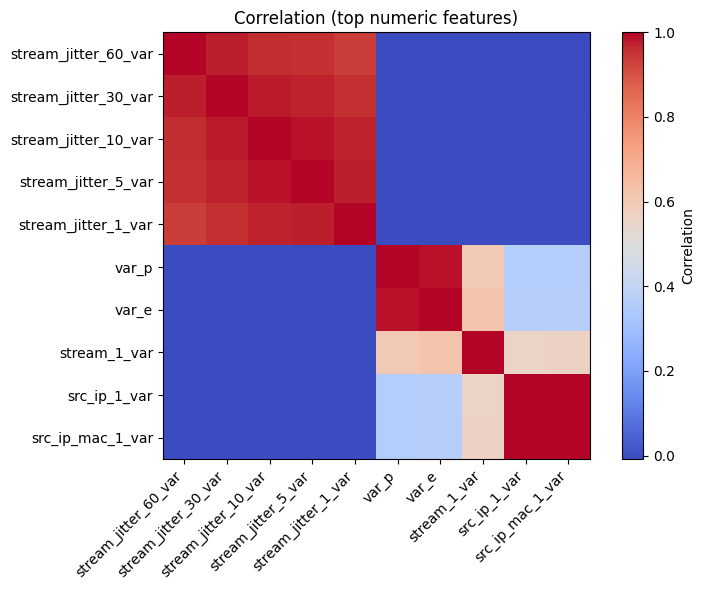

In [24]:
# ============================================================
# 10. Numeric feature variance and correlations
# ============================================================

num_cols = packet_sample.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = packet_sample.select_dtypes(include=["object"]).columns.tolist()

print("\nNumeric columns count:", len(num_cols))
print("Categorical columns count:", len(cat_cols))

numeric_stats = packet_sample[num_cols].describe().transpose()
numeric_stats["variance"] = packet_sample[num_cols].var()

top_var_features = (
    numeric_stats
    .sort_values("variance", ascending=False)
    .head(20)
    .reset_index()
    .rename(columns={"index": "feature"})
)

print("\nTop 20 numeric features by variance:")
print(top_var_features[["feature", "mean", "std", "variance", "min", "max"]])

top_var_features.to_csv(
    REPORTS_DIR / "numeric_top_variance_features_sample.csv",
    index=False,
)

corr_features = top_var_features["feature"].tolist()[:10]
corr_matrix = packet_sample[corr_features].corr()

print("\nCorrelation matrix (subset of high-variance features):")
print(corr_matrix)

corr_matrix.to_csv(
    REPORTS_DIR / "numeric_corr_matrix_top_features_sample.csv",
    index=False,
)

plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap="coolwarm", interpolation="nearest")
plt.xticks(range(len(corr_features)), corr_features, rotation=45, ha="right")
plt.yticks(range(len(corr_features)), corr_features)
plt.colorbar(label="Correlation")
plt.title("Correlation (top numeric features)")
plt.tight_layout()
plt.show()

In [26]:
# ============================================================
# 11. Summary for report/methodology
# ============================================================

print("\n================ SUMMARY: LABEL & FEATURE ANALYSIS ================")
print(f"- Sample size in this notebook           : {len(packet_sample):,} rows")
print(f"- Number of device classes (device_mac)  : {device_counts.shape[0]}")
print(f"- Number of attack classes (attack_label): {attack_counts.shape[0]}")
print("- Device class size buckets (see CSV) show skew: a small number of")
print("  devices have very high packet counts, many have moderate/smaller counts.")
print("- Attack label distribution is imbalanced across families, with")
print("  benign and a few attack types dominating.")
print("- Numeric feature analysis shows several high-variance behavioural")
print("  features (e.g. sizes, timing, entropy), supporting a learned encoder")
print("  based on a shared 1D-CNN + MLP backbone.")
print("===================================================================")


================ SUMMARY: LABEL & FEATURE ANALYSIS ================
- Sample size in this notebook           : 1,200,000 rows
- Number of device classes (device_mac)  : 79
- Number of attack classes (attack_label): 3
- Device class size buckets (see CSV) show skew: a small number of
  devices have very high packet counts, many have moderate/smaller counts.
- Attack label distribution is imbalanced across families, with
  benign and a few attack types dominating.
- Numeric feature analysis shows several high-variance behavioural
  features (e.g. sizes, timing, entropy), supporting a learned encoder
  based on a shared 1D-CNN + MLP backbone.
